In [3]:
import numpy as np
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

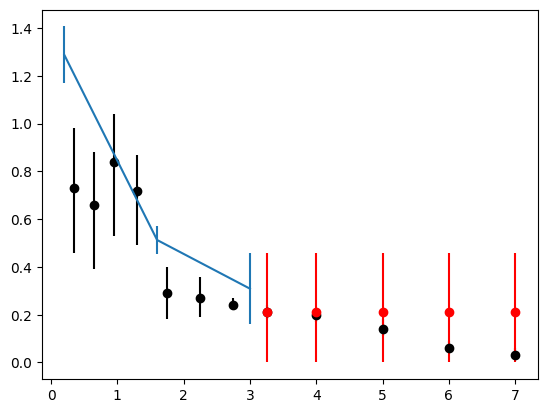

In [33]:
def propagate_cont_error(val, err):
    return abs(val)*abs(np.log(10)*err)

#assumption: declining normalisations with redshift
#little data above z>3, need to be open to having more galaxies at higher redshift due to results from jwst
#lhood or just use mean? if lhood, what width?? maybe just mean, assume small intrinsic scatter
#means are made up, problem?maybe using existing weaver points as mean...
#if have a gp for each, miss correlations between schecter parameters...

weaver_low_mass_norm_val = np.array([0.73, 0.66, 0.84, 0.72, 0.29, 0.27, 0.24, 0.21, 0.20, 0.14, 0.06, 0.03])
weaver_low_mass_norm_errl = np.array([0.27, 0.27, 0.31, 0.23, 0.11, 0.08, 0.02, 0.03, 0.03, 0.03, 0.02, 0.02])
weaver_low_mass_norm_errh = np.array([0.25, 0.22, 0.20, 0.15, 0.11, 0.09, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_low_mass_norm_val, yerr=[weaver_low_mass_norm_errl, weaver_low_mass_norm_errh], fmt='ko')

log_cont_low_mass_norm_val = np.array([-2.89, -3.29, -3.51])
cont_low_mass_norm_val = (10**log_cont_low_mass_norm_val)*1000
cont_low_mass_norm_errl = (propagate_cont_error(cont_low_mass_norm_val, np.array([0.02, 0.02, 0.10]) + np.array([0.02, 0.03, 0.11])))
cont_low_mass_norm_errh = (propagate_cont_error(cont_low_mass_norm_val, np.array([0.02, 0.03, 0.11]) + np.array([0.02, 0.02, 0.10])))
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

plt.errorbar(cont_redshift_anchor_points, cont_low_mass_norm_val, yerr=[cont_low_mass_norm_errl, cont_low_mass_norm_errh])

zg3_index = np.where(weaver_redshift_midpoint>3.0)[0]
zg3_redshifts = weaver_redshift_midpoint[zg3_index]
highz_low_mass_norm_val = np.ones_like(zg3_redshifts)*weaver_low_mass_norm_val[zg3_index[0]]
highz_low_mass_norm_errl = np.ones_like(zg3_redshifts)*weaver_low_mass_norm_val[zg3_index[0]]
high_zlow_mass_norm_errh = np.ones_like(zg3_redshifts)*(cont_low_mass_norm_errh[-1]+(cont_low_mass_norm_val[-1]-weaver_low_mass_norm_val[zg3_index[0]]))

plt.errorbar(zg3_redshifts, highz_low_mass_norm_val, yerr=[highz_low_mass_norm_errl, high_zlow_mass_norm_errh], fmt='ro')


#plt.ylim(0.0, 1.6)

In [ ]:
#apply gp to above, don't bother log, just clip.. or maybe log to get better behaviour close to zero, do I need that really?